<a href="https://colab.research.google.com/github/abelowska/dataPy/blob/main/Classes_10_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In search of the best model (and your ML skills)

Imports

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import cross_val_score, RepeatedKFold
import numpy as np
from scipy import stats
import os

## Load dataset

In [ ]:
data_df, target_df =  datasets.load_diabetes(as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(data_df, target_df, test_size=0.3, random_state=124)

In [ ]:
X_train.to_pickle('X_train_dataset.pkl')
y_train.to_pickle('y_train_dataset.pkl')

## Load and test pickled models

In [ ]:
# path to dir with pickled model
dir_path = 'models'

file_list = os.listdir(dir_path)
pkl_files = [file for file in file_list if file.endswith('.pkl')]

models = []
results_df = pd.DataFrame()

cv = 5

# Loop through each pickle file and load its content
for pkl_file in pkl_files:
  print(f"Loading data from {pkl_file}")
  file_path = os.path.join(dir_path, pkl_file)
  model = pd.read_pickle(file_path)['model'].to_numpy()[0]
  print(model)
  models.append(model)

  model_cv_scores = cross_val_score(model, X_train, y_train, scoring='r2')
  model_cv_mean = np.mean(model_cv_scores)
  model_cv_std = np.std(model_cv_scores)

  model_test_score = model.score(X_test, y_test)

  this_df = pd.DataFrame({
      'model_name': [pkl_file[:-4]],
      'mean_cv_score': [model_cv_mean],
      'sd_cv_score': [model_cv_std],
      'test_score': [model_test_score],
      'model': [model],
  })

  results_df = pd.concat([results_df, this_df], ignore_index=True)

In [ ]:
display(results_df.sort_values(by=["test_score"], ascending=False))

## Best model: Problem 3 - who has created the best model?

It is hard to know whether the difference between mean scores is real or the result of a statistical fluke.

Statistical significance tests are designed to address this problem and quantify the likelihood of the samples of skill scores being observed given the assumption that they were drawn from the same distribution. If this assumption, or null hypothesis, is rejected, it suggests that the difference in skill scores is statistically significant.

**Statistical hypothesis tests can aid in comparing machine learning models and choosing a final model.**

Unfortunately, selecting an appropriate statistical hypothesis test for model selection in applied machine learning is more challenging than it first appears:

In an ideal world, we should have independent N data sets (samples) on which we would evaluate the model, and then compare the results of two models with each other (paired-t-test).

Unfortunately, rarely you will have enough data to train the model N times and evaluate it N times, everything on independent data sets (and we haven't reached the test set yet!).

That's why almost everybody uses CV scores as samples for the t-test in following way:

1. calculate CV scores for model A and model B;
2. calculate the difference between models' performance for each iteration of CV;
3.  perform t-test on those differences.

Following figure shows in a simplified way how such a procedure looks like:

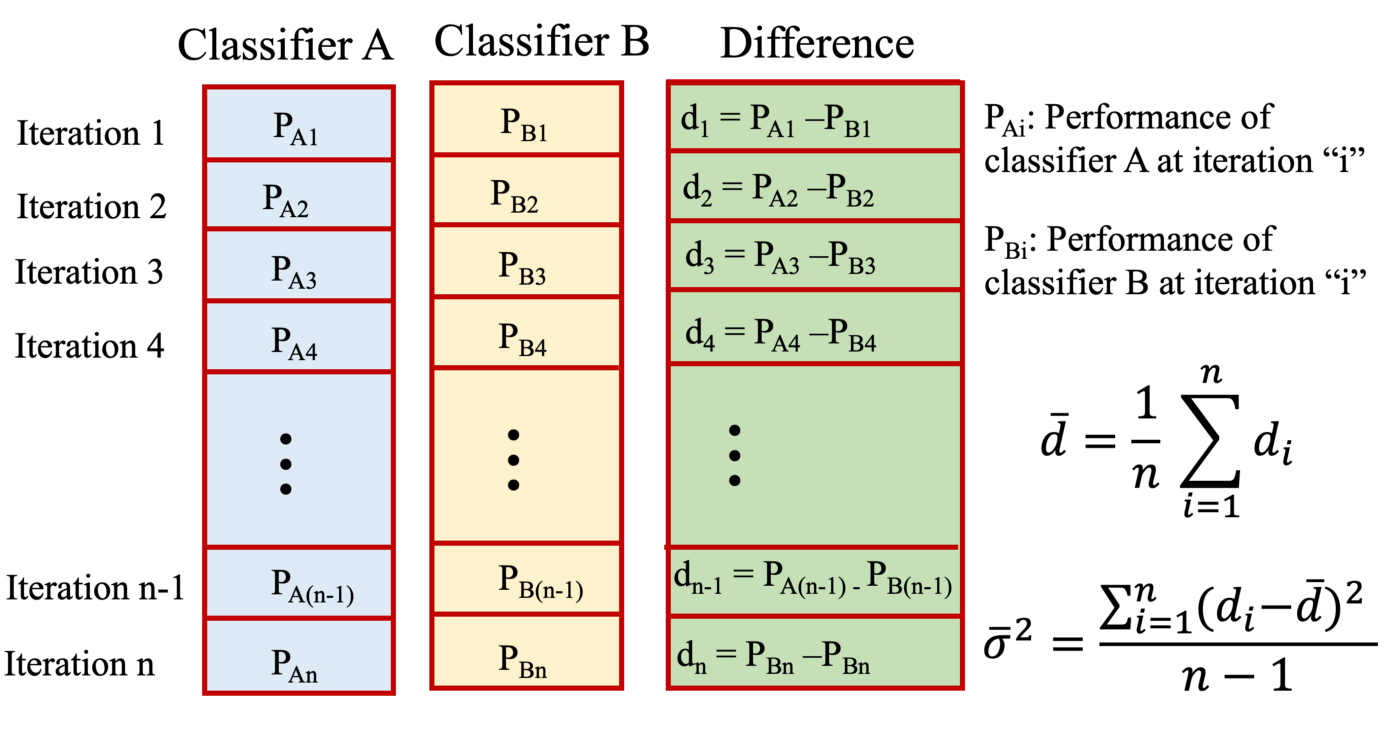

1. Why not simple Student’s t-test on CV scores

  Usage of CV scores violates Student't t-test assumptions!

  The observations in each sample are not independent. As part of the k-fold cross-validation procedure, a given observation will be used in the training dataset (k-1) times. This means that the estimated skill scores are dependent, not independent, and in turn that the calculation of the t-statistic in the test will be misleadingly wrong along with any interpretations of the statistic and p-value.

  **Fortunately, there is a growing body of research that suggests appropriate corrections and alternative methods.**





2. 5×2 Cross-Validation [(Dietterich, 1998)](https://ieeexplore.ieee.org/document/6790639)

  Resampling method: samples came from cross-validation that involves 5 repeats of 2-fold cross-validation.

  > The empirical results show that the 5 × 2cv paired t-test has a Type I error at or below the significance level. However, they also show that it has a much higher Type II error than the standard t-test applied to ten-fold cross-validation. Consequently the former test is recommended in when a low Type I error is essential, and the latter test otherwise.

Implementation and overview: [`mlxtend`](http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/) library.

3. Refinements on 5×2 Cross-Validation: [Nadeau & Bengio (2000)](https://proceedings.neurips.cc/paper/1999/file/7d12b66d3df6af8d429c1a357d8b9e1a-Paper.pdf) corrected t-test

  Resampling method: samples came from cross-validation that involves 10 repeats of 10-fold cross-validation.

  > Empirical results show that this test dramatically improves on the standard resampled t-test: the Type I error is close to the significance level, and, unlike the 5×2 CV test, it does not suffer from high Type II error.

  Implementation: no off-the-shelf implementation. You may have to implement it yourself. Overview and hand-crafted implementation: [scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#comparing-two-models-frequentist-approach) tutorial.



In [ ]:
def paired_ttest_nandeu(
    estimator1,
    estimator2,
    X,
    y,
    random_state=0
):
  """Computes paired-ttest using Nadeau and Bengio's approach.

    Parameters
    ----------
    estimator1 : estimator object implementing 'fit'
        The object to use to fit the data.
    estimator2 :  estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like of shape (n_samples,)
        The target variable to try to predict
    random_state: int


    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_value : float
        Variance-corrected p-value.
    """

  cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=random_state)

  cv_scores_1 = cross_val_score(estimator1, X, y, cv=cv)
  cv_scores_2 = cross_val_score(estimator2, X, y, cv=cv)

  differences = cv_scores_1 - cv_scores_2

  n = differences.shape[0]  # number of test sets
  df = n - 1
  n_train = len(list(cv.split(X, y))[0][0])
  n_test = len(list(cv.split(X, y))[0][1])

  t_stat, p_value = compute_corrected_ttest(differences, df, n_train, n_test)

  return t_stat, p_value


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * ((1 / kr) + (n_test / n_train))
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = stats.t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [ ]:
def pairwise_ttest_estimates(results_df, X_train, y_train, random_state=0):
    n = len(results_df)
    matrix = np.zeros(shape=(n,n))

    for i in range(n):
        for j in range(n):
          estimator_1 = results_df['model'].iloc[i]
          estimator_1_name = results_df['model_name'].iloc[i]

          estimator_2 = results_df['model'].iloc[j]
          estimator_2_name = results_df['model_name'].iloc[j]

          t, p = paired_ttest_nandeu(
              estimator1=estimator_1,
              estimator2=estimator_2,
              X=X_train,
              y=y_train,
              random_state=random_state
            )
          print(f'Comapring following estimators: {estimator_1_name} vs {estimator_2_name}')
          print('t statistic: %.3f' % t)
          print('p value: %.3f' % p)
          matrix[i][j] = p

    model_names = results_df['model_name'].to_numpy().flatten()
    df = pd.DataFrame(matrix, columns=model_names, index=model_names)


    return df

In [ ]:
ttest_results_df = pairwise_ttest_estimates(results_df, X_train, y_train)

In [ ]:
display(ttest_results_df)